In [22]:
import numpy as np
import matplotlib.pyplot as plt
from math import log
from scipy.stats import kstest
import scipy.stats as st
import seaborn as sns
import scipy.integrate as integrate

# Sampling from random variables

This is an exercise notebook on how to generate random numbers from a r.v. $Y$ given its cumulative distribution function.

We have seen
 -  Direct methods
 -  Acceptance-rejection method
 
Remember to revise the lecture on sampling before attempting to solve it!


### Pseudo-random number generation
#### Linear congruential generators (LCGs)

Define a function `sample_from_uniform()` that takes `N` as input and returns a sequence $x_1,\dots,x_N$, where $x_i\sim\mathcal{U}(0,1)$ $\forall 1\le i\le N$. Use the LCGs algorithm with a proper choice for parameters `a`, `c` and `m`, which are going to be passed as input to the function.

Start with a seed $z_0\in\mathbb{N}$ and define the sequence of integers $z_i = (a\cdot z_{i-1}+c)(mod\quad m)$. 
Then $u_i = \frac{z_i}{m}\in [0,1)$. 

Remember to choose $m$ very large and pick $a$ and $c$ in order to generate a *full-period* sequence.

In [1]:
def _get_next(z, a, c, m):
    return (a*z+c)%m
    
def sample_from_uniform(N,seed=1):
    a=1664525
    c=1013904223
    m=2**32
    samples=np.zeros(N)
    samples[0]=seed
    for i in range(N-1):
        samples[i+1]=_get_next(samples[i],a,c,m)
    return samples/m

Text(0.5, 1.0, 'Uniform')

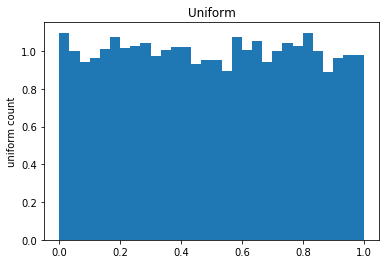

In [2]:
samples=sample_from_uniform(10000)
plt.hist(samples, density=True, bins=30)
plt.ylabel('uniform count')
plt.title("Uniform")

#### $\chi^2$-test
Once you have generated the `N` random variates $x_1,\dots ,x_N$, use the $\chi^2$-test to find out whether
*$H_0$: "$x_1,\dots ,x_N\sim\mathcal{U}(0,1)$ are indipendent"* can be accepted.

In [7]:
from scipy.stats import chisquare
n_obs_per_bin,bin_edges = np.histogram(samples,bins=20)
print(n_obs_per_bin)
print(bin_edges)

# When just f_obs is given, it is assumed that the expected frequencies are uniform 
# and given by the mean of the observed frequencies.
chisquare(f_obs=n_obs_per_bin)

[546 467 497 520 505 524 507 494 497 473 464 509 515 488 495 529 540 454
 500 476]
[2.32830644e-10 4.99997850e-02 9.99995698e-02 1.49999355e-01
 1.99999139e-01 2.49998924e-01 2.99998709e-01 3.49998494e-01
 3.99998278e-01 4.49998063e-01 4.99997848e-01 5.49997633e-01
 5.99997417e-01 6.49997202e-01 6.99996987e-01 7.49996772e-01
 7.99996556e-01 8.49996341e-01 8.99996126e-01 9.49995911e-01
 9.99995695e-01]


Power_divergenceResult(statistic=23.884, pvalue=0.20063966560076904)

The p-value is higher than the significance level (0.05), so we accept the null hypothesis that the observations are independent.

###  Inversion method

This method involves computing the CDF of the distribution (which maps a number in the domain to a probability between $0$ and $1$) and then inverting that function.

Idea: Generate $u\in\mathcal{U}(0,1)$. The sampled value $y$ is then computed as $y = F^{-1}(u)$.

Note that for a discrete distribution, computing the CDF is not in general too difficult: we simply add up the individual probabilities for the various points of the distribution. For a continuous distribution, however, we need to integrate the probability density function (PDF) of the distribution, which is impossible to do analytically for most distributions, making this method computationally inefficient for many distributions; however, it is a useful method for building more generally applicable samplers such as those based on rejection sampling.


**Exponential distribution:** define a function `sample_from_exp()`, which takes as inputs the parameter `lambda` and the length of the ouput sequence `N`. The function should sample from the r.v. $Y\sim Exp(\lambda )$ using the inversion method. Recall that $y=F(x) = 1-\exp^{-\lambda x}$.

In [16]:
%%time

inv_exp_cdf = lambda x, lamb: -(1/lamb) * log(1-x)

def sample_from_exp(lamb, N):
    # sample from a uniform
    u = sample_from_uniform(N)
    # invert values
    y = [inv_exp_cdf(x, lamb) for x in u]
    return y

# choose a fixed lambda>0
lamb=1
exp_samples = sample_from_exp(lamb, 100000)

n_obs_per_bin,bin_edges = np.histogram(exp_samples,bins=20)
print(n_obs_per_bin)

[46251 24710 13375  7140  4013  2085  1148   646   262   168    98    39
    29    15    13     1     2     3     1     1]
CPU times: user 112 ms, sys: 0 ns, total: 112 ms
Wall time: 111 ms


Text(0.5, 1.0, 'Exponential')

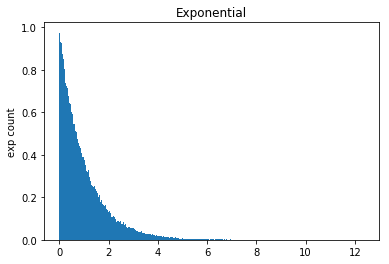

In [18]:
plt.hist(exp_samples, density=True, bins=300)
plt.ylabel('exp count');
plt.title("Exponential")

**Kolmogorov–Smirnov test** 
KS is one of the most useful and general nonparametric methods for measuring the goodness of fit of a distribution.
The Kolmogorov–Smirnov statistic quantifies a distance between the empirical distribution function of the sample and the cumulative distribution function of the reference distribution. The null distribution of this statistic is calculated under the *null hypothesis* that the sample is drawn from the reference distribution. 

Build a function `ks_test()` that assess wheter or not your sample represent a good fit for the desired distribution. Use the *scipy.stats.kstest* library.

In [213]:
%%time
kstest(exp_samples,'expon',args=(0,1/lamb))

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 17.8 ms


KstestResult(statistic=0.002020412474200095, pvalue=0.8089682554735161)

### Sampling from discrete random variable

Implement the algorithm `sample_discrete_rv()` which extract random samples $x_i$ from a finite vector $p(\mathbf{x}=[p(x_1),\dots ,p(x_N)]$ assuming $\sum_i p(x_i) = 1$. Remember that sorting the values of $p(\mathbf{x})$ may make the algorithm more efficient.

In [16]:
%%time
# not efficient
p=np.array([0.1,0.3,0.2,0.3,0.1])

def sample_discrete_rv(value, p):
    indexes=np.cumsum(p)
    print(indexes)
    i=0
    while(value >= indexes[i]):
        i = i+1
    return i

sample_discrete_rv(0.88, p)

[0.1 0.4 0.6 0.9 1. ]
CPU times: user 0 ns, sys: 1.75 ms, total: 1.75 ms
Wall time: 5.8 ms


!!!! correggere pesca valori che non sono nel vettore

In [17]:
%%time
# efficient
p=np.array([0.1,0.3,0.2,0.3,0.1])
print(np.sum(p))

def sample_discrete_rv(value, p):
    sorted_idxs = np.argsort(p)
    sorted_p = p[sorted_idxs]
    indexes=np.cumsum(sorted_p)
    print(indexes)
    i=0
    while(value >= indexes[i]):
        i = i+1
    return sorted_idxs[i]

sample_discrete_rv(0.88, p)

1.0000000000000002
[0.1 0.2 0.4 0.7 1. ]
CPU times: user 1.39 ms, sys: 316 µs, total: 1.71 ms
Wall time: 1.72 ms


### Acceptance-rejection method
Rejection sampling is a basic technique to generate observations from a distribution. The method works for any distribution in $\mathbb {R} ^{m}$ with a density. It's used where direct methods fail.

Define a funtion `rejection_sampling()` which takes an input density `f(x)` of the target distribution.
In the basic implementation a uniform $g(x)$ is sufficient.


Sketch:

1. generate y with density $r= \frac{g(x)}{c}$, where $g(x)$ is a function majorizing the density $f(x)$ and $c = \int_{-\infty}^{\infty}g(x)dx$;
2. generate $u\in\mathcal{U}(0,1)$;
3. if $u\le\frac{f(y)}{g(y)}$ return $x=y$, otherwise reject and go to step 1.

In [236]:
def rejection_sampling(f, # target density
                       proposal_params=[15,10], # params of the proposal distribution
                       xrange=[-10,30], # xrange for draws
                       N=1000): # number of draws
    samples=[]
    
    # normal proposal distribution
    g = lambda x: st.norm.pdf(x, proposal_params[0], proposal_params[1])
    
    x = np.linspace(xrange[0], xrange[1],10000)
    k = max(f(x) / g(x))
    
    #c = k*integrate.quad(g, proposal_params[0], proposal_params[1])[0]
    
    for i in range(N):
        # 1.
        y = np.random.normal(proposal_params[0], proposal_params[1])#/c
        
        # 2.
        u = np.random.uniform(0, k*g(y))
        
        # 3.
        if u <= f(y):
            samples.append(y)
    
    # plotting the results
    plt.plot(x, f(x))
    plt.plot(x, k*g(x))
    plt.show()
    sns.distplot(samples)
            
    return np.array(samples)

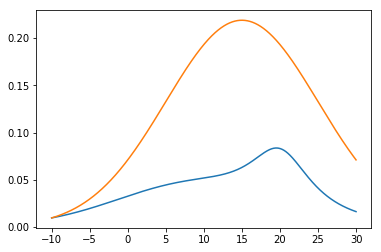

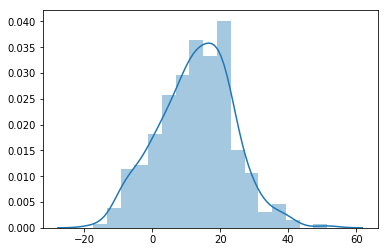

In [237]:
def f(x):
    return st.norm.pdf(x, loc=8, scale=10) + st.cauchy.pdf(x, loc=20, scale=5)

samples = rejection_sampling(f=f)

**Beta distribution** consider $X\sim Beta(\alpha,\beta)$. Define a function `sample_from_beta()` which takes as input the parameters `alpha`, `beta` and a integer `N` and returns a sample of length N. As before, check the fitness with the KS test.

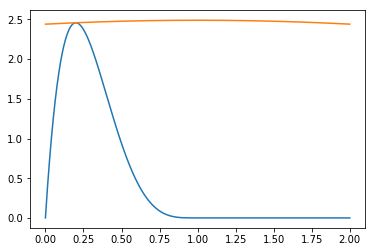

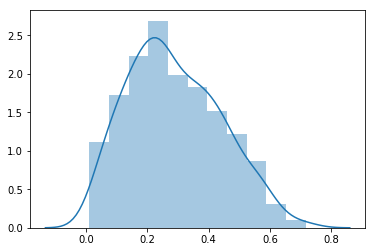

In [221]:
def sample_from_beta(alpha, beta, N):
    return rejection_sampling(lambda x: st.beta.pdf(x, alpha, beta), proposal_params=[1,5], xrange=[0,2], N=N)

samples = sample_from_beta(alpha=2, beta=5, N=10000)

In [223]:
%%time
kstest(samples,'beta',args=(2,5))

CPU times: user 2.48 ms, sys: 0 ns, total: 2.48 ms
Wall time: 1.64 ms


KstestResult(statistic=0.046139462236983675, pvalue=0.5249740608857308)

Improve computational efficiency: use the inversion method for a discrete random variable to refine the function that majorize $f$ in the previous exercise. 


Show the improvement in time w.r.t. $N$: i.e. time to the solution for increasing values of $N$ for the simple case and the refined one. in terms of reduced rejection rate and overall sampling time.

In [1]:
# inversion method case

def rejection_sampling(f, # target density
                       proposal_params=[15,10], # params of the proposal distribution
                       xrange=[-10,30], # xrange for draws
                       N=1000): # number of draws
    samples=[]
    
    # normal proposal distribution
    g = lambda x: st.norm.pdf(x, proposal_params[0], proposal_params[1])
    
    # refine g using inversion method
    
    inv_exp_cdf = lambda x, lamb: -(1/lamb) * log(1-x)

    def sample_from_exp(lamb, N):
        # sample from a uniform
        u = sample_from_uniform(N)
        # invert values
        y = [inv_exp_cdf(x, lamb) for x in u]
        return y

    
    x = np.linspace(xrange[0], xrange[1],10000)
    k = max(f(x) / g(x))
    
    #c = k*integrate.quad(g, 0, 1)[0]
    for i in range(N):
        # 1.
        y = np.random.normal(proposal_params[0], proposal_params[1])
        
        # 2.
        u = np.random.uniform(0, k*g(y))
        
        # 3.
        if u <= f(y):
            samples.append(y)
    
    # plotting the results
    plt.plot(x, f(x))
    plt.plot(x, k*g(x))
    plt.show()
    sns.distplot(samples)
            
    return np.array(samples)sion method case


SyntaxError: invalid syntax (<ipython-input-1-9d0f281d4e56>, line 45)